In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Read the CSV file containing EUR/USD exchange rate data
df = pd.read_csv("dataset/EURUSDH4.csv", delimiter="\t")
#df = pd.read_csv("dataset/EURUSD_Daily_200005300000_202405300000.csv", delimiter="\t")


# Extract the closing prices from the DataFrame
closing = df["<CLOSE>"].iloc[0:1000]

def generate_triangle_wave_data(n_points=5000, amplitude=1.0, period=5):
    data = []
    for i in range(n_points):
        data.append(amplitude * (2 * (i % period) / period - 1))
    return np.array(data)

# Generate triangle wave data
#data = generate_triangle_wave_data(period=4) + generate_triangle_wave_data(period=6) + generate_triangle_wave_data(period=5)
#closing = pd.Series(data=data)

# Use the moving average instead of the raw closing prices
#moving_average = closing.rolling(window=5).mean().dropna()  # Drop NaN values from the start

#closing = df["<HIGH>"]

# # Normalize the data if not already done
# closing = (closing - closing.mean()) / closing.std()

def visibility_condition(prices, i, j):
    """Check if node j is visible from node i."""
    for k in range(i + 1, j):
        if prices[k] >= prices[i] + (prices[j] - prices[i]) * (k - i) / (j - i):
            return False
    return True

def create_nvg(prices):
    N = len(prices)
    G = nx.Graph()
    
    for i in range(N):
        G.add_node(i, feature=prices[i])
        for j in range(i + 1, N):
            visibility = True
            for k in range(i + 1, j):
                # Linear interpolation between points i and j at point k
                expected_value_at_k = prices[i] + (prices[j] - prices[i]) * (k - i) / (j - i)
                
                # Check if point k obstructs the visibility
                if prices[k] >= expected_value_at_k:
                    visibility = False
                    break
            if visibility:
                G.add_edge(i, j)
                
    return G

def plot_nvg_with_prices(prices, nvg, window_start, window_size):
    """Plot the NVG connections over the time series data."""
    plt.figure(figsize=(10, 6))
    
    # Plot the closing prices
    plt.plot(range(window_start, window_start + window_size), prices, label="Closing Prices", color='blue')
    
    # Overlay the NVG connections
    for edge in nvg.edges():
        i, j = edge
        plt.plot([window_start + i, window_start + j], [prices[i], prices[j]], color='red', linestyle='-', linewidth=0.8)
    
    # Adding labels and title
    plt.title(f"Closing Prices with NVG Connections (Window {window_start} to {window_start + window_size - 1})")
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Define the sliding window size
window_size = 20

# Generate NVGs for each sliding window
sliding_window_graphs = []
sliding_window_data = []
for i in range(len(closing) - window_size + 1):
    window_data = closing[i:i + window_size].values
    
    # Normalize the data for each window
    window_data = (window_data - window_data.mean()) / window_data.std()
    sliding_window_data.append(window_data)
    
    G = create_nvg(window_data)
    sliding_window_graphs.append((G, i))



In [9]:
print(window_data.std(), " " , window_data.mean())

1.0   -9.803269307440132e-15


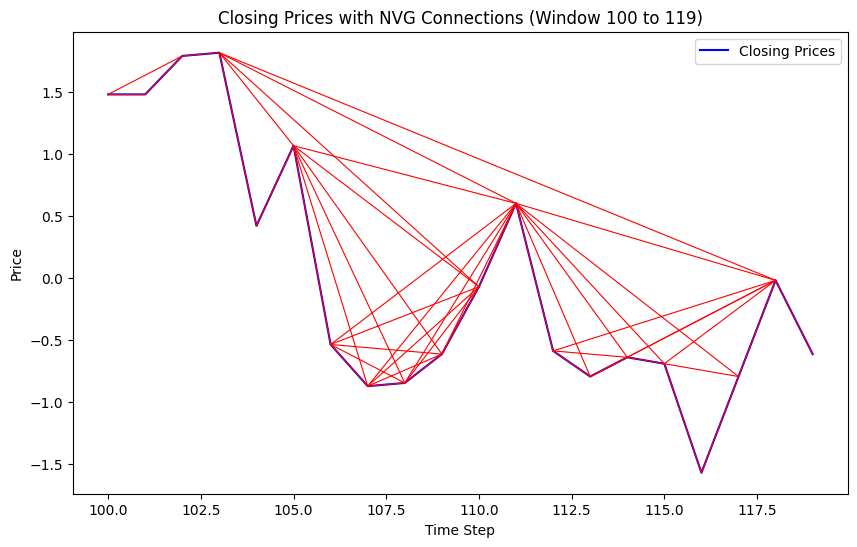

In [10]:
# Plot the NVG and prices for the first sliding window
IDX = 100
first_window_graph, first_window_start = sliding_window_graphs[IDX]
# plot_nvg_with_prices(closing[first_window_start:first_window_start + window_size], first_window_graph, first_window_start, window_size)
plot_nvg_with_prices(sliding_window_data[IDX], first_window_graph, first_window_start, window_size)

	1.	Iterate Over All Sliding Windows: We’ll loop through all the sliding windows to perform any necessary operations on each NVG.
	2.	Store Graphs for Model Training: We will prepare the graphs and features in a format suitable for graph-based machine learning models.
	3.	Feature Masking and Edge Management: Mask the feature of the last node in each window and handle the edges accordingly.

In [46]:
sliding_window_data[0]

array([-1.91421858e+00, -1.35363777e+00,  1.74604434e+00,  1.61414297e+00,
       -1.64876708e-03, -1.02388436e+00, -3.97352866e-01, -5.29254232e-01,
       -4.96278891e-01,  2.95129307e-01,  9.21660797e-01,  1.51521694e+00,
        9.87611480e-01,  1.05356216e+00,  2.95129307e-01, -7.27106281e-01,
       -2.98426841e-01, -2.65451500e-01, -7.93056965e-01, -6.28180257e-01])

In [12]:
#!pip install torch_geometric

In [13]:
import torch
import numpy as np
from torch_geometric.utils import from_networkx
import torch.nn.functional as F

# Iterate over all sliding windows and prepare data for model training
graph_data_list = []
# window_size = 100

for G, start_idx in sliding_window_graphs:
    # Extract the node features (closing prices)
    node_features = np.array([G.nodes[n]['feature'] for n in G.nodes])
    
    # Mask the last node's feature (the "future" price, which we want to predict)
    last_node = max(G.nodes)
    node_features[last_node] = np.nan  # Masking the future node's feature
    
    # Convert NetworkX graph to PyTorch Geometric format
    graph_data = from_networkx(G)
    
    # Assign features to the graph
    graph_data.x = torch.tensor(node_features, dtype=torch.float).view(-1, 1)
    
    # Store the processed graph
    graph_data_list.append(graph_data)

# Let's print a summary of the first graph data structure
print("Summary of the first graph:")
print(graph_data_list[0])

# If you were to use this in a model, you might want to handle the NaN value in the last node,
# e.g., by zero-imputing or using a mask during training.

Summary of the first graph:
Data(edge_index=[2, 100], feature=[20], num_nodes=20, x=[20, 1])


	1.	Define the VGAE Model: We’ll define the encoder and the VGAE model.
	2.	Training Loop: Set up the training loop to process the graph data, focusing on reconstructing the graph and predicting the masked node features.
	3.	Loss Function: Include the standard loss components (reconstruction loss and KL divergence) and optionally add visibility constraint handling.

In [ ]:
import torch
from torch_geometric.nn import GCNConv, VGAE
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir="runs/transformer_experiment")

if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

# TODO: if predicted and real close price dont match increase model complexity

class VGAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(VGAEEncoder, self).__init__()
        # Add more layers and increase the number of hidden channels
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv_mu = GCNConv(hidden_channels, out_channels)
        self.conv_logvar = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()  # Added a third convolutional layer
        return self.conv_mu(x, edge_index), self.conv_logvar(x, edge_index)

# Increase the hidden channels (complexity) and latent space dimensionality
in_channels = 1
hidden_channels = 16  # Increase this to make the model more complex
out_channels = 8  # Larger latent space

# Initialize the model, optimizer, and loss function components
encoder = VGAEEncoder(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels).to(device)
model = VGAE(encoder).to(device)


LR = 0.0001
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

# Function to handle NaN values in node features (e.g., zero-imputation)
def handle_nan(x):
    return torch.nan_to_num(x, nan=0.0)

# Visibility loss function
def visibility_loss_specific(z, ohlc_values, specific_edges):
    loss = torch.tensor(0.0, device=z.device)  # Initialize as a tensor on the correct device
    for i, j in specific_edges:
        if not visibility_condition(ohlc_values, i, j):
            predicted_similarity = (z[i] * z[j]).sum()
            loss += F.relu(predicted_similarity)  # Penalize positive similarity for invalid edges
    return loss

def visibility_condition(prices, i, j):
    """Check if node j is visible from node i."""
    for k in range(i + 1, j):
        if prices[k] >= prices[i] + (prices[j] - prices[i]) * (k - i) / (j - i):
            return False
    return True

# Training loop
epochs = 1000
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_vis_loss = 0
    total_link_loss = 0
    total_kl_loss = 0
    
    for graph_data in graph_data_list:
        optimizer.zero_grad()
        
        # Handle NaN in features and move data to the correct device
        graph_data.x = handle_nan(graph_data.x).to(device)
        graph_data.edge_index = graph_data.edge_index.to(device)
        
        # Forward pass through the model to get the latent variables
        z = model.encode(graph_data.x, graph_data.edge_index)
        
        # Decode to reconstruct the graph (edges)
        edge_logits = model.decode(z, graph_data.edge_index)
        link_loss = F.binary_cross_entropy_with_logits(edge_logits, torch.ones(edge_logits.size(0), device=device))
        
        # KL Divergence Loss (using internally stored mu and logvar)
        kl_loss = model.kl_loss()
        
        # Visibility Loss for specific edge(s)
        last_node = graph_data.x.size(0) - 1
        # All Nodes
        #specific_edges = [(0, last_node)]
        # Emphasise on last 5
        specific_edges = [(last_node - 5, last_node)]
        
        
        vis_loss = visibility_loss_specific(z, graph_data.x, specific_edges).to(device)
     
        
        # Total loss with dynamic weighting of KL loss
        vis_loss_weight = 0.5  # Smaller weight for visibility loss
        kl_weight = 1 / (1 + epoch)  # Decrease the influence of KL loss over time
        loss = link_loss + kl_weight * kl_loss + vis_loss_weight * vis_loss
      
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_vis_loss += vis_loss.item()  # Ensure to use .item() for scalar values
        total_link_loss += link_loss.item()
        total_kl_loss += (kl_weight * kl_loss).item()

    scheduler.step(metrics=total_loss)
    # Write Loss per Epoch
    writer.add_scalar('Loss/Epoch', total_loss, epoch )
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.9f}, Visibility Loss: {total_vis_loss:.4f}, Link Loss: {total_link_loss:.4f}, KL Loss: {total_kl_loss:.4f}")
# Close writer    
writer.close()
# After training, we can test the model or analyze the results.


cuda
Epoch 1/1000, Loss: 868.1482, LR: 0.000100000, Visibility Loss: 712.5888, Link Loss: 477.4903, KL Loss: 34.3635
Epoch 2/1000, Loss: 784.3910, LR: 0.000100000, Visibility Loss: 604.4943, Link Loss: 478.2921, KL Loss: 3.8518


In [37]:
torch.save(model.state_dict(), "knowlege_check_point/model.pt")

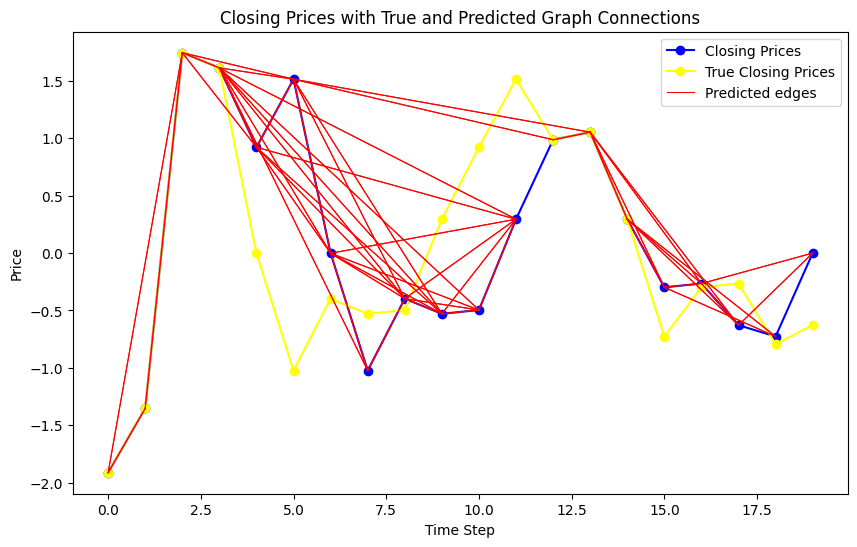

In [48]:
import matplotlib.pyplot as plt
import networkx as nx

plot_true_edges = False
idx = 0


# Generate the true graph using the visibility rules
true_graph = create_nvg(graph_data_list[idx].x.cpu().numpy().flatten())  # Assuming the features are normalized

# Generate the predicted graph
model.eval()
with torch.no_grad():
    z = model.encode(graph_data_list[idx].x, graph_data_list[idx].edge_index)
    sampled_graph = model.decode(z, graph_data_list[idx].edge_index)

# Threshold the output to decide on the edges
sampled_graph = torch.sigmoid(sampled_graph).cpu().numpy()
thresholded_graph = (sampled_graph > 0.5).astype(int)

# Extract the prices (closing values) for plotting
prices = graph_data_list[idx].x.cpu().numpy().flatten()
prices_true = sliding_window_data[idx]

# Plot the price time series
plt.figure(figsize=(10, 6))
plt.plot(prices, color='blue', linestyle='-', marker='o', label='Closing Prices')
plt.plot(prices_true, color='yellow', linestyle='-', marker='o', label='True Closing Prices')

if plot_true_edges:
    # Overlay the edges of the true graph
    counter = 0
    for edge in true_graph.edges():
        i, j = edge
        if counter==0:
            plt.plot([i, j], [prices[i], prices[j]], color='green', linestyle='-', linewidth=2.8, label='True edges')
        else:
            plt.plot([i, j], [prices[i], prices[j]], color='green', linestyle='-', linewidth=2.8)
        counter += 1

# Overlay the edges of the predicted graph
counter = 0
for idx, (u, v) in enumerate(graph_data_list[idx].edge_index.T.cpu().numpy()):
    if thresholded_graph[idx] == 1:
        if counter==0:
            plt.plot([u, v], [prices[u], prices[v]], color='red', linestyle='-', linewidth=.8, label='Predicted edges')
        else:
            plt.plot([u, v], [prices[u], prices[v]], color='red', linestyle='-', linewidth=.8)
        counter += 1

plt.title("Closing Prices with True and Predicted Graph Connections")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.show()

In [43]:
# Assuming `model` is your trained VGAE or similar model
# `graph_data` is the data you're evaluating on

# Encode and decode to get predicted edges
model.eval()
with torch.no_grad():
    z = model.encode(graph_data.x, graph_data.edge_index)
    edge_logits = model.decode(z, graph_data.edge_index)

# Threshold the logits to decide which edges exist
edge_probs = torch.sigmoid(edge_logits)
threshold = 0.5  # Commonly used threshold
predicted_edges_mask = (edge_probs > threshold)

# The indices of the edges in `graph_data.edge_index` that are predicted as present
predicted_edges_indices = predicted_edges_mask.nonzero(as_tuple=False).flatten()

# Get the actual edge indices corresponding to the predicted edges
predicted_edges_set = set(
    (graph_data.edge_index[0, idx].item(), graph_data.edge_index[1, idx].item()) 
    for idx in predicted_edges_indices
)

# Now use `predicted_edges_set` instead of `predicted_G.edges()`
tp = len(true_edges & predicted_edges_set)
fp = len(predicted_edges_set - true_edges)
fn = len(true_edges - predicted_edges_set)

# Precision, Recall, F1-Score
precision = tp / (tp + fp) if tp + fp > 0 else 0
recall = tp / (tp + fn) if tp + fn > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")

NameError: name 'true_edges' is not defined